<a href="https://colab.research.google.com/github/Danya05/optimization_algo/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22qsgd_diana_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

In [ ]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = np.array(wine_quality.data.features)
y = np.array(wine_quality.data.targets)[:, 0]

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

X.shape, y.shape

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

((4898, 11), (4898,))

In [ ]:
data = wine_quality.data.features.sample(X.shape[0])
X = np.array(data)
y = np.array(wine_quality.data.targets.iloc[data.index])[:, 0]
X_parts = []
y_parts = []
const_size = X.shape[0] // mp.cpu_count()
for i in range(mp.cpu_count()):
    X_parts.append(X[i * const_size : (i + 1) * const_size])
    y_parts.append(y[i * const_size : (i + 1) * const_size])

In [ ]:
width = 20
height = 8
sns.set(rc = {'figure.figsize':(width,height)})
sns.set_theme()

In [ ]:
def compute_gradient(X, y, a, theta):
    gradient1 = 2 * (X.T).dot(X.dot(theta) - y) / X.shape[0] +  2 * a * theta
    return gradient1

def mse(X, y, theta):
  return (np.square(np.subtract(y, X.dot(theta))).mean())

def quantization_of_gradient(gradient, dec=3):
    return np.round(gradient, decimals=dec)


def gradient_descent(X, y, a, learning_rate=0.001, num_iterations=1500, m = 1):
    data = []
    data_norm_grad = []
    theta = np.zeros(X.shape[1])
    for _ in range(num_iterations):
        gradient = compute_gradient(X, y, a, theta)
        data.append(mse(X, y, theta))
        gradient = quantization_of_gradient(gradient)
        theta = (theta - learning_rate * gradient)
        data_norm_grad.append(np.linalg.norm(gradient))
    return data, data_norm_grad

In [ ]:
a = 100
full_data, full_data_norm_grads = gradient_descent(X, y, a, learning_rate = 1 / (2 * np.max(np.linalg.eigvals(X.T.dot(X)) / X.shape[0]) + 2 * a))

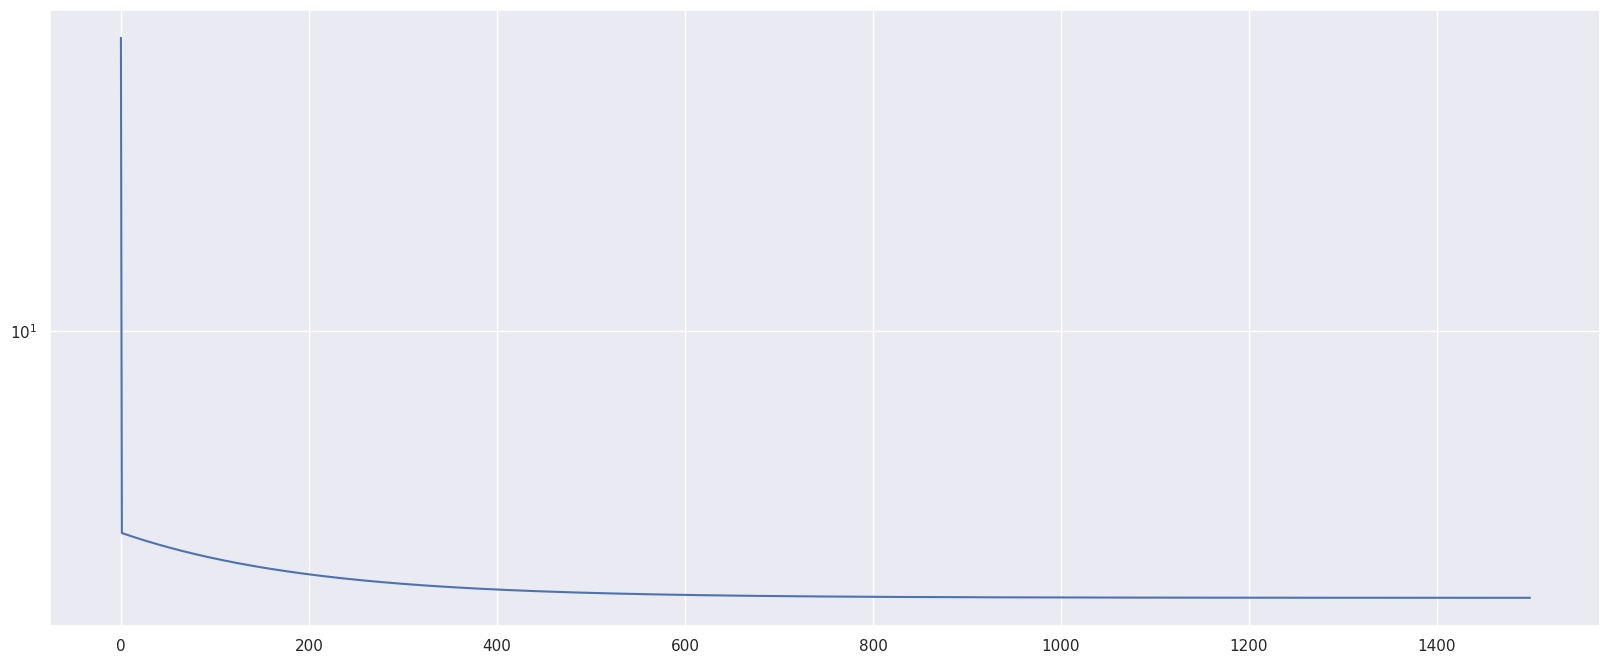

In [ ]:
plt.semilogy(full_data) # Log mse

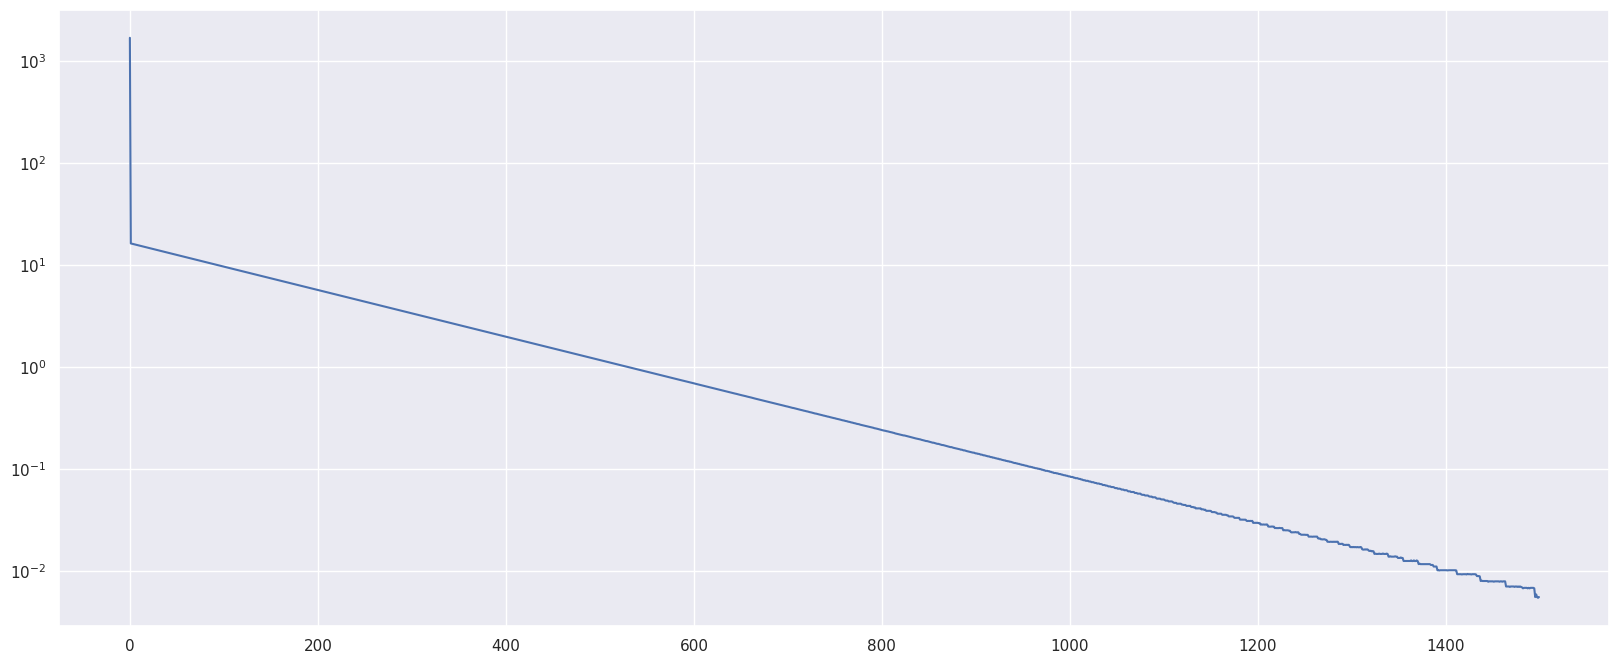

In [ ]:
plt.semilogy(full_data_norm_grads) # Log norm_grad

In [ ]:
def worker(X, y, a, theta, grad, h, delta, alpha, num_of_workers):
    for i in range(num_of_workers):
        grad[i] = compute_gradient(X, y, a, theta)
        delta[i] = grad[i] - h[i]
        #delta[i] = quantization_of_gradient(delta[i])
        #grad[i] = h[i] + delta[i]
        h[i] = h[i] + alpha * delta[i]

def diana(X, y, a, num_of_workers=mp.cpu_count(), learning_rate=0.001, num_iterations=1000, m = 1, alpha = 0.5):
    theta = np.zeros(X.shape[1])  # Инициализация параметров единичными значениями
    deltas_parts_from_workers = np.zeros( (num_of_workers, X.shape[1] ))
    #deltas_parts_from_workers = np.full((num_of_workers, X.shape[1]), 0)
    grad = np.full((num_of_workers, X.shape[1]), 0)
    h = np.zeros((num_of_workers, X.shape[1]))
    h1 = sum(h) / num_of_workers
    #print(h1)
    data1 = []
    data2 = []
    for _ in range(num_iterations):


        for i in range(num_of_workers):

            worker(X_parts[i], y_parts[i], a, theta, grad, h, deltas_parts_from_workers, alpha, num_of_workers)

        delta = (sum(deltas_parts_from_workers) / len(deltas_parts_from_workers))
        gradient = h1 + delta

        #data1.append(np.linalg.norm(compute_gradient(X, y, a, theta) - gradient))
        # gradient = quantization_of_gradient(gradient)

        data2.append(np.linalg.norm(gradient))
        data1.append(mse(X, y, theta))

        theta = (theta - learning_rate * gradient)
        h1 = h1 + alpha * delta

    return data1, data2

In [ ]:
a_diana = 50
diana_data, diana_data_norm_grads = diana(X, y, a_diana, 1, 1 / (2 * np.max(np.linalg.eigvals(X.T.dot(X)) / X.shape[0]) + a_diana))

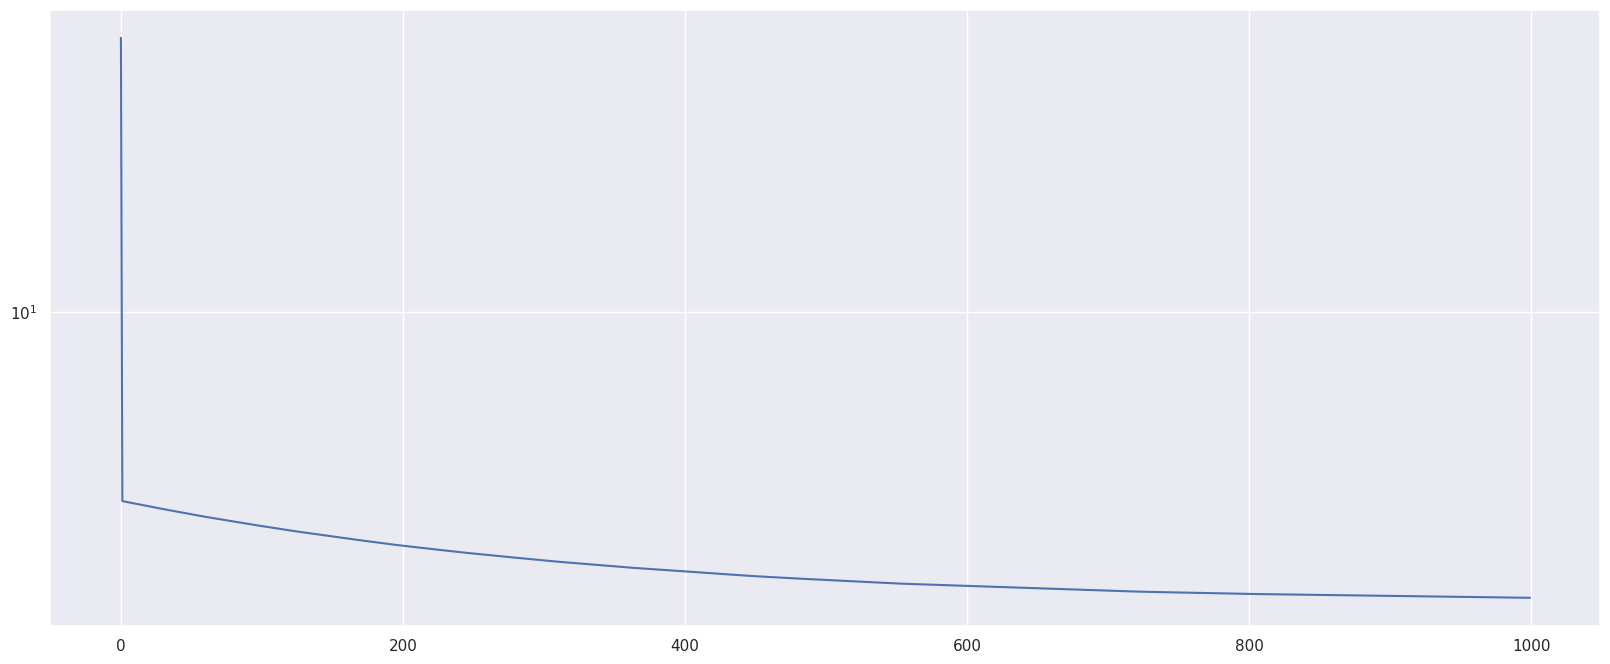

In [ ]:
plt.semilogy(diana_data) # Log mse

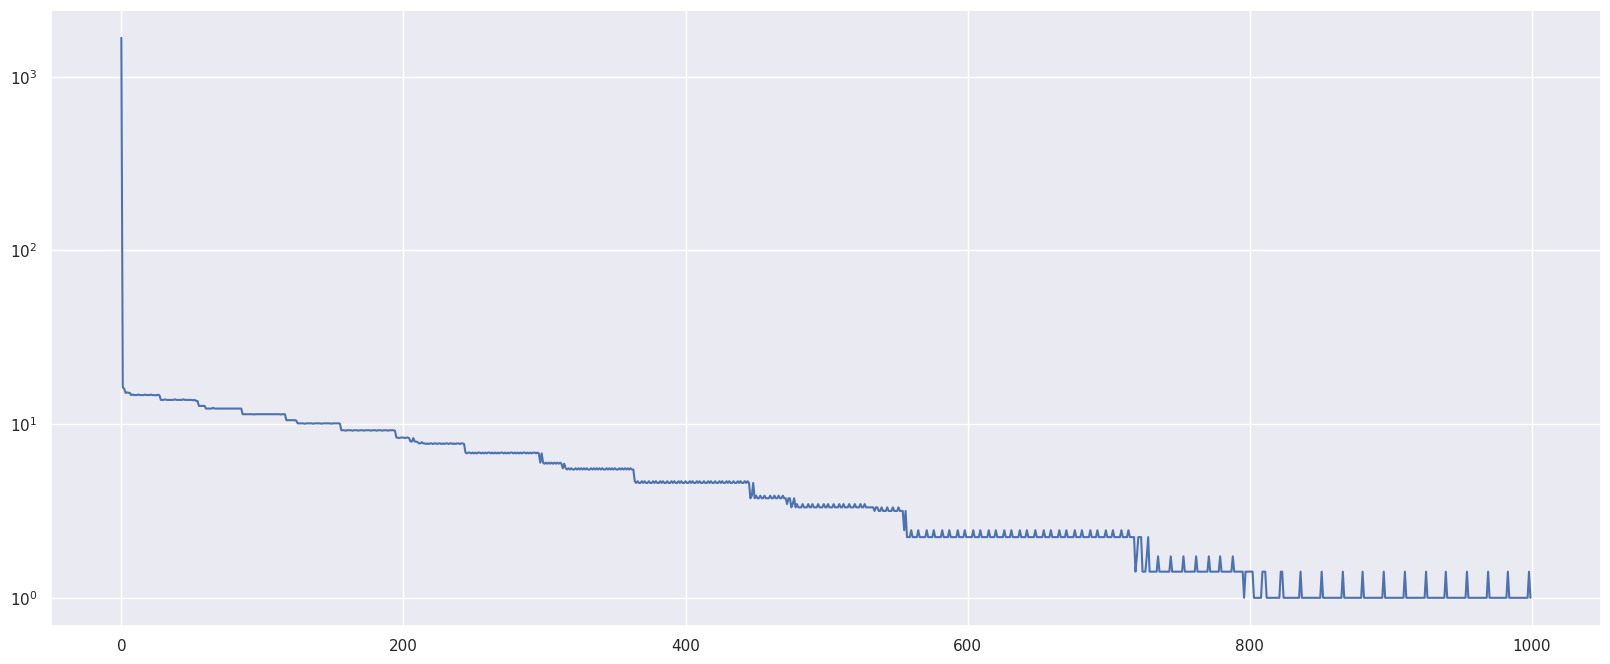

In [ ]:
plt.semilogy(diana_data_norm_grads) # Log norm_grad